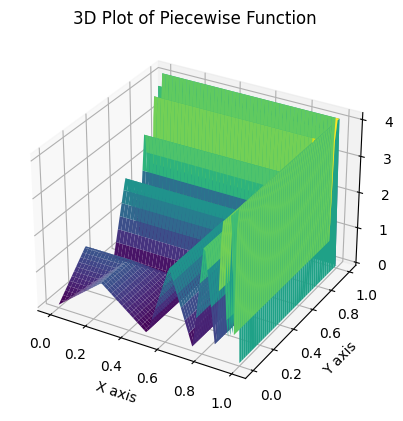

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
# Definition of the sum function f(j)
def f_j(j):
    return 1 - (1/2)**j

# Piecewise function definition
def triangle_function(x, max_j=10):
    for j in range(1, max_j + 1):
        f_j_start = f_j(j -1)
        f_j_end = f_j(j)
        midpoint = (f_j_start + f_j_end) / 2
        
        if f_j_start <= x <= f_j_end:
            if x <= midpoint:
                return 2 * (x - f_j_start) / (f_j_end - f_j_start) *j#* (1/j )
            else:
                return 2 * (f_j_end - x) / (f_j_end - f_j_start) *j#* (1/j )
    return 0

def triangle_tensor(X):
    vectorized_function = np.vectorize(triangle_function)
    y = torch.linalg.vector_norm(X,ord = float('inf'), dim = 1)
    out = vectorized_function(y.detach().numpy())
    return torch.tensor(out, dtype = torch.float32).reshape(-1,1)



x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()
Y_flat = Y.flatten()
mesh_data = np.stack((X_flat, Y_flat), axis=1)
x = torch.tensor(mesh_data)
output = triangle_tensor(x)
Z = output.reshape(100, 100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z, cmap='viridis')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Plot of Piecewise Function')
plt.show()

In [ ]:
class NN(nn.Module):
    def __init__(self, h):
        super(NN, self).__init__()
        h = [1] + h
        layers = []
        for layer in range(1,len(h)):
            layers.append(nn.Linear(h[layer -1], h[layer]))
            layers.append(nn.ReLU())
        self.univariate_nn = nn.Sequential(*layers)
    def forward(self, x):
        return self.univariate_nn(x)

In [88]:

class Lipschitz_Linear(nn.Module):
    def __init__(self, h, activation = None):
        super(Lipschitz_Linear, self).__init__()
        self.B = 2 ## Upper bound on product of weights norms
        self.lip_reg = 0.0005 ## learning rate on Lip regularisation !
        self.order = float('inf') ### order of L_j norm
        h = h
        self.activation = activation
        layers = []
        self.linear_layers = []
        self.Norm_constraints = torch.rand(len(h) - 1) * self.B
        for layer in range(1,len(h)):
            linear = nn.Linear(h[layer -1], h[layer])
            layers.append(linear)
            layers.append(nn.BatchNorm1d(h[layer], affine=True))
            self.linear_layers.append(linear)
            if activation is not None:
                layers.append(self.activation())
        self.univariate_nn = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.univariate_nn(x)
    
    def compute_constraint_gradient(self):
        self.grads_norm_constraints = []
        prod = torch.prod(self.Norm_constraints)
        for i in range(len(self.Norm_constraints)):
            grad = torch.sum(self.linear_layers[i].weight.grad * (self.linear_layers[i].weight.data / (torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)))) + self.lip_reg * (prod / self.Norm_constraints[i])  * torch.exp(7 * ((prod) - self.B))
            self.grads_norm_constraints.append(grad)

    def upper_lipschitz_bound(self):
        return torch.prod(self.Norm_constraints)

    def update_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.Norm_constraints[i] -= 0.001 * self.grads_norm_constraints[i]
    
    def project_on_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.linear_layers[i].weight.data *= self.Norm_constraints[i] / torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)
    
    def train_enforce_constraints(self):
        self.compute_constraint_gradient()
        self.update_norm_constraints()
        self.project_on_norm_constraints()





In [91]:
test = Lipschitz_Linear([1,4,16,4,1], activation = nn.ReLU)
def f(X):
    return X**0.23
X = torch.vstack((torch.rand(1000, 1), torch.zeros(1000 //20 ,1)))
train_dataset = torch.utils.data.TensorDataset(X, f(X))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
epochs = 1  # Number of epochs to train
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.RAdam(test.parameters(), lr=0.001)
for epoch in range(epochs):
    test.train()  # Set the model to training mode
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = test(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        test.train_enforce_constraints()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
print("Training Complete!")
print()


Epoch [1/1], Loss: 0.7197
Training Complete!



In [124]:
class KAN_NN_Layer(nn.Module):
    def __init__(self, in_dim, h, out_dim):
        super(KAN_NN_Layer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.Network_stack = nn.ModuleList()
        self.linear = nn.ModuleList()
        for _ in range(out_dim):
            Networks = nn.ModuleList()
            for _ in range(self.in_dim):
                Networks.append(Lipschitz_Linear([1] + h, activation = nn.ReLU))
            self.Network_stack.append(Networks)
            self.linear.append(Lipschitz_Linear([in_dim * h[-1], 1]))

    def forward(self, x):
        out = torch.zeros((x.shape[0],self.out_dim))
        for i in range(self.out_dim):
            output_list = []
            for j in range(self.in_dim):
                output_list.append(self.Network_stack[i][j](x[:,j].reshape(-1,1)))
            out[:,i] = self.linear[i](torch.cat(output_list, dim=1)).view(-1)
        return out

    def train_enforce_constraints(self):
        for i in range(self.out_dim):
            for j in range(self.in_dim):
                self.Network_stack[i][j].train_enforce_constraints()
            self.linear[i].train_enforce_constraints()

         


In [125]:
class KAN_NN(nn.Module):
    def __init__(self, h, hidden):
        super(KAN_NN, self).__init__()
        self.layers = []
        for layer in range(1,len(h)):
            self.layers.append(KAN_NN_Layer(h[layer -1],hidden,h[layer]))
        self.Kan_nn = nn.Sequential(*self.layers)
    def forward(self, x):
        return self.Kan_nn(x)
    
    def train_enforce_constraints(self):
        for KAN_Lip_NN_Layer in self.layers:
            KAN_Lip_NN_Layer.train_enforce_constraints()

        


In [142]:
def f(x):
    # Fixed exponents between 0 and 1
    alpha = 0.5
    beta = 0.7
    gamma = 0.3
    delta = 0.8
    epsilon = 0.6
    omega = 0.4
    
    # First term: (x^alpha + (1 - x)^beta)^gamma
    term1 = 10*torch.sum(x ** alpha, dim = 1)
    term2 = 2*torch.sum((1.0001 - x) ** beta, dim = 1)
    # Second term: (sin(2πx)^delta)^epsilon
    term3 = torch.abs(torch.sin(2 * torch.pi * torch.sum(x**delta, dim = 1)))
    term4= torch.sum(x**0.3, dim = 1)
    result = (torch.abs((torch.sin(2 * torch.pi * (term1 ** .5)) + torch.cos(20 * torch.pi * (term2 ** .4))))**omega + torch.abs((term3**.67 + term4**0.1)))
    return torch.reshape(result, [result.shape[0], 1])

In [134]:
X = torch.rand(1000, in_dim) 
train_dataset = torch.utils.data.TensorDataset(X, f(X))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
X = torch.rand(100, in_dim)
test_dataset = torch.utils.data.TensorDataset(X, f(X))
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)

In [143]:
in_dim = 2
model = KAN_NN([in_dim,4,2,1], [4,32,4])

Epoch [1/1000], Loss: 7.8838, Testloss: 9.3240
Epoch [2/1000], Loss: 7.6218, Testloss: 8.2149
Epoch [3/1000], Loss: 7.4062, Testloss: 7.9313
Epoch [4/1000], Loss: 7.1887, Testloss: 7.5036
Epoch [5/1000], Loss: 6.9476, Testloss: 6.5478
Epoch [6/1000], Loss: 6.7416, Testloss: 7.3205
Epoch [7/1000], Loss: 6.5156, Testloss: 6.0549
Epoch [8/1000], Loss: 6.2976, Testloss: 6.8258
Epoch [9/1000], Loss: 6.1046, Testloss: 6.5444
Epoch [10/1000], Loss: 5.9225, Testloss: 6.5391
Epoch [11/1000], Loss: 5.7996, Testloss: 6.3422
Epoch [12/1000], Loss: 5.6218, Testloss: 5.6954
Epoch [13/1000], Loss: 5.4471, Testloss: 5.4649
Epoch [14/1000], Loss: 5.2749, Testloss: 5.6845
Epoch [15/1000], Loss: 5.1248, Testloss: 5.8563
Epoch [16/1000], Loss: 4.9934, Testloss: 5.1847
Epoch [17/1000], Loss: 4.8309, Testloss: 5.1351
Epoch [18/1000], Loss: 4.6967, Testloss: 4.8148
Epoch [19/1000], Loss: 4.5544, Testloss: 4.7670
Epoch [20/1000], Loss: 4.4301, Testloss: 4.6202
Epoch [21/1000], Loss: 4.2861, Testloss: 4.6461
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [1000/1000], Loss: 0.1387, Testloss: 0.1098


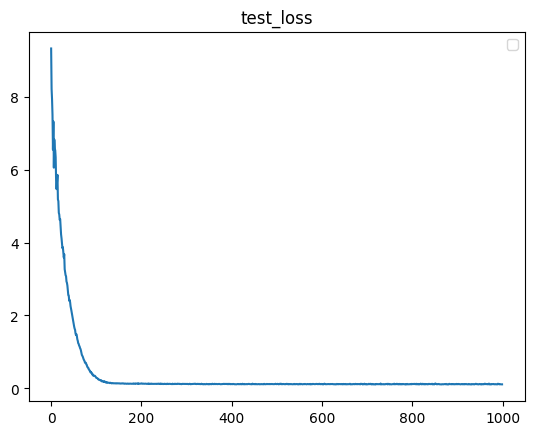

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


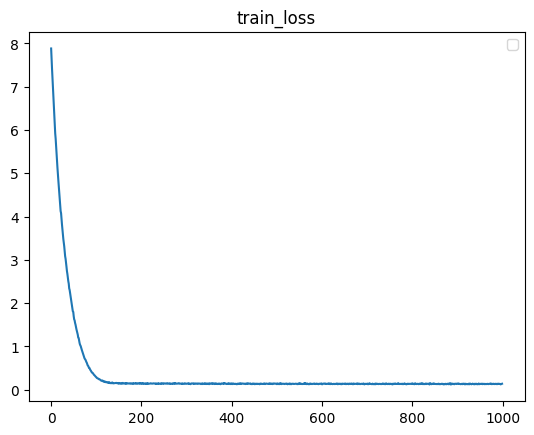

Training Complete!


In [144]:
epochs = 1000  # Number of epochs to train
criterion = nn.MSELoss(reduction='mean')  # Mean Squared Error Loss
criterion_test = nn.MSELoss(reduction='sum')  # Mean Squared Error Loss
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_loss = []
test_loss = []
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0 
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        #model.train_enforce_constraints()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    train_loss.append(avg_loss)
    num_samples = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            model.eval()
            outputs = model(inputs)
            loss = criterion_test(outputs, targets)
            running_loss += loss.item()
            num_samples += inputs.size(0)
        avg_loss_test = running_loss / num_samples
        #print(num_samples, len(test_dataloader))
    test_loss.append(avg_loss_test)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Testloss: {avg_loss_test:.4f}")
plt.plot(test_loss)
plt.title('test_loss')
plt.legend()
plt.show()
plt.plot(train_loss)
plt.title('train_loss')
plt.legend()
plt.show()


print("Training Complete!")